# Gun Detection System for Urban Settings (_Feature extraction_)

This notebook details the feature extraction techniques applied on the processed sound files. 

In [ ]:
import librosa
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import math
from PIL import Image
import os

import warnings
warnings.filterwarnings('ignore')
matplotlib.use("Agg")
%matplotlib inline

First, some constant values are set to be used across the entire notebook

In [ ]:
IMG_DIR = "./mel-specs"
VAL_DIR = "./mel-specs-val"
TEST_DIR = "./mel-specs-test"

SAMPLE_RATE = 22050 # Justification for this value is provided later

### II.IV Feature Extraction

The splitted sets are first loaded into numpy array to prepare for extraction.

**_Loading data sets_**

In [ ]:
def load_x_and_y_helper(path):
    x = []
    y = []
    
    files = librosa.util.find_files(path, ext=['wav'])
    files = np.asarray(files)
    for file in files:
        if '.wav' in file:
            name = file.split('/').pop()
            label = name.split('.')[0].split('-')[1];
            wave_arr, sr = librosa.load(file, sr = SAMPLE_RATE, mono = True)
            x = x + [wave_arr]
            y = y + [label]
    print('done!')
    return np.array(x), np.array(y, dtype=int)


def load_x_and_ys():
    print('collecting training set...', end = "")
    X_train, y_train = load_x_and_y_helper('./processed_data/train')
    print('collecting validation set...', end = "")
    X_val, y_val = load_x_and_y_helper('./processed_data/val')
    print('collecting test set...', end = "")
    X_test, y_test = load_x_and_y_helper('./processed_data/test')
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_x_and_ys()

collecting training set...done!
collecting validation set...done!
collecting test set...done!


*PS: the y vactor now contains the ID of classes \[0-9\] instead of the categorical names*

In [ ]:
X_train.shape, y_train.shape

((7000, 44100), (7000,))

For this project, two approaches will be implemented for comparison, **Mel-spectrogram classification** and **multi-feature stacking**.<br/>
First, all audio arrays will be converted to Mel-spectrograms in preparation for the first approach. <br/>
Then, relevant 1D feature vectors will be extracted from the same original sets and stacked in preparation for the second approach.

**_Mel-spectrogram images_**

Using librosa, all audio slices will be converted into 2D mel-spectrogram matrix. The matrix will then be saved in the form of a heatmap-like image. The construction of those images takes a very long time so the resulted images will be saved to disk to be loaded later when the training phase starts. This will allow for more experimentation in the training phase without the need to recompute the images each time.

When the resulting mel-spectrogram is images is saved, it is saved as a diagram with x-axis and y-axis, as well as an extra empty white border frame (see example below). All audios have the same length and sample rate so they all share the same scale of the x-axis and y-axis. Thus, the axes, labels, and border are redundant and may cause confusion for the CNN model, leading it to learn irrelevant features and lower the training quality. For these reasons, after saving the spectrogram images, the `resize_images` function is called to loop through the output images and crop the unecessary data, leaving only the spectrogram heatmap in the picture.  

In [ ]:
def resize_images(base_path=IMG_DIR):
    subfolders = [f.path for f in os.scandir(base_path) if f.is_dir()]
    images = []
    
    for fold_path in subfolders:
        for file in os.listdir(fold_path):
            if '.png' in file:
                path = "{}/{}".format(fold_path, file)
                im = Image.open(path)
                width, height = im.size

                left = 81
                top = 59
                right = width - 64
                bottom = height - 53

                im1 = im.crop((left, top, right, bottom))
                im1.save(path)
                images += [im1]
                
                im.close()
    return images

def convert_to_mel_specs(X, y, base_path=IMG_DIR, show_example=False):
    if not os.path.exists(base_path):
        os.mkdir(base_path)
        
    for label in label_map.keys():
        sub_fold = "{}/{}".format(base_path, label)
        if not os.path.exists(sub_fold):
            os.mkdir(sub_fold)

    X_mel_specs = []
    for idx, wav in enumerate(X):
        spec = librosa.feature.melspectrogram(y=wav.astype(float), sr=SAMPLE_RATE)
        X_mel_specs = X_mel_specs + [spec]
        
        fig = plt.Figure()
        ax = fig.add_subplot(111)
        p = librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), ax=ax, y_axis='log', x_axis='time')
        fig.savefig("{}/{}/{}-{}.png".format(base_path, get_class_name(int(y[idx])), idx, y[idx]))

    ims = resize_images(base_path)
    
    return X_mel_specs, ims

In [ ]:
X_specs_train, images = convert_to_mel_specs(X_train, y_train)

Original photo of the mel-spectrogram:


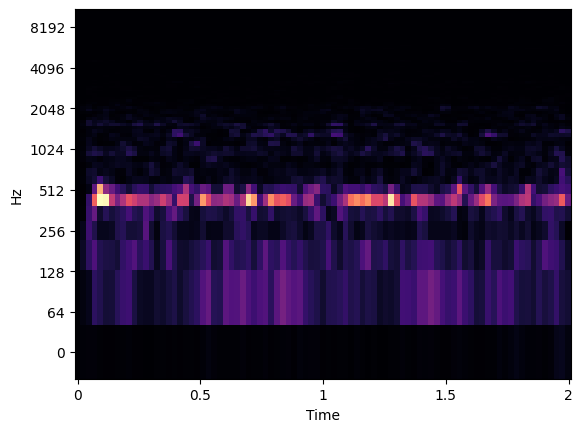

The final cropped image:


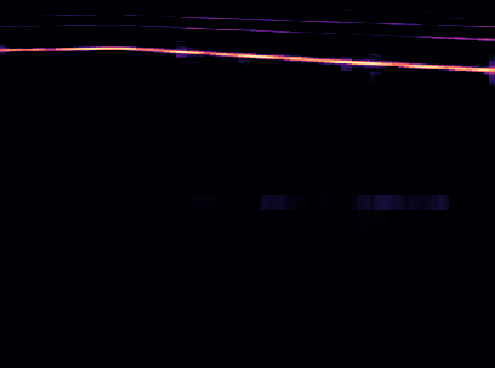

In [ ]:
print('Original photo of the mel-spectrogram:')
p = librosa.display.specshow(X_specs_train[0], sr=SAMPLE_RATE, x_axis='time', y_axis='log');
plt.show()
print('The final cropped image:')
images[0]

*PS: Those two images are not of the same sound wave as PIL Image shuffles the order of the original set of images.*

In [ ]:
X_specs_val = convert_to_mel_specs(X_val, y_val, VAL_DIR)

In [ ]:
X_specs_test = convert_to_mel_specs(X_test, y_test, TEST_DIR)

In [ ]:
org_shape = np.array(X_specs_train).shape
org_shape

(7000, 128, 87)

The raw specs array is saved in csv file for future use

In [ ]:
def save_specs_arr(arr, name):
    np.savetxt("./processed_data/{}.txt".format(name), np.array(arr).reshape(len(arr), -1))
    
def load_specs_arr(name):
    arr = np.loadtxt("./processed_data/{}.txt".format(name))
    arr = arr.reshape(arr.shape[0], arr.shape[1] // org_shape[2], org_shape[2])
    return arr

In [ ]:
save_specs_arr(X_specs_train, 'training_mel_specs')
save_specs_arr(X_specs_val, 'val_mel_specs')
save_specs_arr(X_specs_test, 'test_mel_specs')

**_1D stacked vectors_**

For the second approach, a 1D vector is extracted from each audio clip representing this audio. This vector is the result of stacking different features describing the same audio wave. Five features will be computed from each audio: Mel-spectrogram, MFCCs, spectral contrast feature, chromagram and tonnetz. Each of these features will be then converted from a 2D matrix to a 1D array by taking the mean across the vertical axis. According to a study in [[1]](https://www.researchgate.net/publication/365912955_Multi-feature_stacking_order_impact_on_speech_emotion_recognition_performance), the orders in which these features are stacked is significantly impactful on the final result. Therefore, following their recommended order, the features are horizontally stacked in the following order: spectral contrast, tonnetz, chromagram, Mel-spectrogram, and MFCC. The resulting vectors are then inputted into the classifier.

In [ ]:
def extract_stacked_feats(X):
    mfccs = librosa.feature.mfcc(y=X, sr=SAMPLE_RATE, n_mfcc=40)
    _1D_mfcc = np.mean(mfccs.T, axis=0)
    
    chromagram = librosa.feature.chroma_stft(y=X, sr=SAMPLE_RATE)
    _1D_chroma = np.mean(chromagram.T, axis=0)

    mel_spec = librosa.feature.melspectrogram(y=X, sr=SAMPLE_RATE)
    _1D_mel = np.mean(mel_spec.T, axis=0)

    contrast = librosa.feature.spectral_contrast(y=X, sr=SAMPLE_RATE)
    _1D_contrast = np.mean(contrast.T, axis=0)

    harmonic = librosa.effects.harmonic(X)
    tonnetz = librosa.feature.tonnetz(y=harmonic, sr=SAMPLE_RATE)
    _1D_tonnetz = np.mean(tonnetz.T,axis=0)
    
    
    return np.hstack([_1D_contrast, _1D_tonnetz, _1D_chroma, _1D_mel, _1D_mfcc])

def extract_stacked_feature_arrays(X):
    data = [];
    
    print('extracting', end="")
    progress = 0;
    for idx in range(len(X)):
        if(idx == int(progress * len(X))):
            print('.', end="")
            progress += 0.1
            
        stack = extract_stacked_feats(X[idx])
        data = data + [stack]
    print('done!')
    
    return np.array(data)

In [ ]:
print('Training set: ', end='')
X_stack_train = extract_stacked_feature_arrays(X_train)
print('Validation set: ', end='')
X_stack_val = extract_stacked_feature_arrays(X_val)
print('Test set: ', end='')
X_stack_test = extract_stacked_feature_arrays(X_test)

X_stack_train.shape

Training set: extracting...........done!
Validation set: extracting...........done!
Test set: extracting...........done!


(7000, 193)

The 1D feature vectors are saved in csv format for future use.

In [ ]:
def export_stacked_feature_arrays(X, y, split='train'):
    path = './processed_data/stacked_features'
    if not os.path.exists(path):
        os.mkdir(path)
    
    print('exporting {} set...'.format(split), end=' ')
    np.savetxt("{}/X_{}.csv".format(path, split), X, delimiter=",")
    y.tofile('{}/y_{}.csv'.format(path, split), sep = ',')
    print('done!')

In [ ]:
export_stacked_feature_arrays(X_stack_train, y_train)
export_stacked_feature_arrays(X_stack_val, y_val, split='val')
export_stacked_feature_arrays(X_stack_test, y_test, split='test')

exporting train set... done!
exporting val set... done!
exporting test set... done!
